# Mars image recognition

In [13]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
data_folder = '../data/hirise-map-proj-v3_2/'

In [3]:
def extract_metadata() -> pd.DataFrame:
    images_and_labels = None
    with open(data_folder + 'labels-map-proj_v3_2_train_val_test.txt', 'r') as f:
        images_and_labels = f.readlines()
    images_and_labels = pd.DataFrame(images_and_labels).replace('\n', '', regex=True)[0].str.split(' ', expand=True)
    images_and_labels.rename(columns={0: 'file_name', 1: 'label', 2: 'type'}, inplace=True)
    return images_and_labels

In [4]:
metadata = extract_metadata()

In [5]:
train_data = metadata[metadata['type'] == 'train']
test_data = metadata[metadata['type'] == 'test']
val_data = metadata[metadata['type'] == 'val']

In [6]:
def image_to_np(image: pd.Series) -> np.array:
    return np.asarray(PIL.Image.open(data_folder + 'map-proj-v3_2/' + image['file_name']))

In [7]:
def get_data(data: pd.DataFrame) -> tuple:
    labels = data['label']
    data = data.apply(image_to_np, axis=1)
    return np.stack(data.to_numpy()), np.stack(labels.to_numpy()).astype(float)

In [8]:
train_data, train_labels = get_data(train_data)
test_data, test_labels = get_data(test_data)
val_data, val_labels = get_data(val_data)

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 1)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

2022-03-15 00:50:40.109882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 00:50:40.109901: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 00:50:40.109914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ArchPC): /proc/driver/nvidia/version does not exist
2022-03-15 00:50:40.110113: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8))

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=5, validation_data=(val_data, val_labels))

Epoch 1/5


2022-03-15 00:50:56.405124: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2630967682 exceeds 10% of free system memory.


1596/1596 [==============================] - ETA: 0s - loss: 1.4794 - accuracy: 0.8001

2022-03-15 01:11:19.169338: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 770822311 exceeds 10% of free system memory.


1596/1596 [==============================] - 1277s 800ms/step - loss: 1.4794 - accuracy: 0.8001 - val_loss: 0.9560 - val_accuracy: 0.7551
Epoch 2/5
1596/1596 [==============================] - 1270s 795ms/step - loss: 0.8123 - accuracy: 0.8030 - val_loss: 1.0360 - val_accuracy: 0.7597
Epoch 3/5
1596/1596 [==============================] - 1273s 797ms/step - loss: 0.7771 - accuracy: 0.8178 - val_loss: 1.1170 - val_accuracy: 0.7599
Epoch 4/5
1596/1596 [==============================] - 1293s 810ms/step - loss: 0.6493 - accuracy: 0.8396 - val_loss: 1.1224 - val_accuracy: 0.7600
Epoch 5/5
1596/1596 [==============================] - 1281s 802ms/step - loss: 0.5386 - accuracy: 0.8640 - val_loss: 1.3186 - val_accuracy: 0.7476


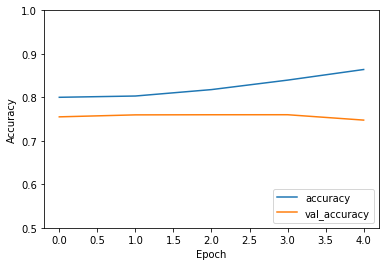

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [16]:
test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=2)

57/57 - 7s - loss: 1.1048 - accuracy: 0.8148 - 7s/epoch - 122ms/step


In [18]:
print(test_acc)

0.8148354887962341


In [22]:
model.save('./model')

INFO:tensorflow:Assets written to: ./model/assets
